In [1]:
import pandas as pd
import numpy as np
import torch
import utils.print as print_f
import os

from utils.engine import evaluate, get_iou_types
from utils.plot import plot_losses, plot_performance
from data.strs import TaskStrs, SourceStrs, FusionStrs

from models.utils import get_model_size_in_MB
from models.build import create_model_from_setup
from models.setup import ModelSetup
from models.train import TrainingInfo, get_task_metric_name_from_standard
from utils.save import check_best, end_train, get_data_from_metric_logger
from data.load import get_datasets, get_dataloaders
from IPython.display import clear_output
from utils.eval import get_performance
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup, get_coco_eval_params, get_dynamic_loss
from utils.init import reproducibility, clean_memory_get_device
from data.paths import MIMIC_EYE_PATH
# from datetime import datetime
# from models.dynamic_loss import DynamicWeightedLoss
from utils.engine import train_one_epoch, evaluate
from torch import optim
from models.setup import ModelSetup
from data.paths import MIMIC_EYE_PATH, PHYSIONET_PATH
from models.load import load_cl_pretrained

# from data.load import seed_worker, get_dataloader_g

## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore")

from models.components.task_performers import ObjectDetectionPerformer
from data.constants import DEFAULT_MIMIC_CLINICAL_NUM_COLS, DEFAULT_MIMIC_CLINICAL_CAT_COLS

%matplotlib inline

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
# 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [3]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [4]:
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [5]:
# fix backbones
from models.load import CLPretrainedLoadParams

common_args = {
    "decoder_channels": [128, 64, 32, 16, 8],
    "optimiser": "sgd",
    "lr": 3e-3,  # 1e-5,  # 1e-3 is a trainable value.
    "sgb_momentum": 0.9,
    "weight_decay": 1e-2,  # 1e-5s
    # "pretrained": True,
    # "image_size": 128,
    "record_training_performance": False,
    "warmup_epochs": 10,
    "lr_scheduler": "ReduceLROnPlateau",  # ReduceLROnPlateau, MultiStepLR
    "reduceLROnPlateau_factor": (1 - 1e-10),
    "reduceLROnPlateau_patience": 9999999,  # only used for tracking customised early stop.
    "real_stop_patience": 99999999999999999,
    "reduceLROnPlateau_full_stop": True,  # set to false to continue run.
    "multiStepLR_milestones": [20, 40, 60, 80, 100],  # list(range(1,100)),
    "multiStepLR_gamma": 0.5,
    "gt_in_train_till": 0,
    "box_head_dropout_rate": 0,
    "model_warmup_epochs": 0,  # stop fixing the weights in the backbone.
    "loss_warmup_epochs": 0,  # should be larger than model warm up.
    "measure_test": True,
    "use_dynamic_weight": True,
    "iou_thrs": np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]),
    "maxDets": [1, 5, 10, 30],
    "normalise_clinical_num": True,
    "use_clinical_df": True,  # for nature?
}

batch_size_256_args = {
    "batch_size": 256,
}

batch_size_512_args = {
    "batch_size": 512,
}

batch_size_4_args = {
    "batch_size": 4,
}


image_128_args = {
    "image_size": 128,
}


image_512_args = {
    "image_size": 512,
}


bb_to_mask_args = {
    "lesion_detection_use_mask": True,
}

clinical_using_backbone_args = {
    "using_backbone_for_clinical": True,
}

clinical_not_using_backbone_args = {
    "using_backbone_for_clinical": False,
}
fusion_1D_args = {"clinical_lesion_detection_use_1D_fusion": True}

no_fusion_1D_args = {"clinical_lesion_detection_use_1D_fusion": False}

clinical_deconv_upsample_args = {"clinical_upsample": "deconv"}

clinical_repeat_upsample_args = {"clinical_upsample": "repeat"}

clinical_interpolate_upsample_args = {"clinical_upsample": "interpolate"}

silent_report_args = {"fiaxtions_mode_input": "silent"}

full_report_args = {"fiaxtions_mode_input": "normal"}

reporting_report_args = {"fiaxtions_mode_input": "reporting"}

# chexpert_best_args = {
#     "performance_standard_task": TaskStrs.CHEXPERT_CLASSIFICATION,
#     "performance_standard_metric": "auc",
# }

# negbio_best_args = {
#     "performance_standard_task": TaskStrs.NEGBIO_CLASSIFICATION,
#     "performance_standard_metric": "auc",
# }


chexpert_best_args = {
    "performance_standards": [
        {
            "task": TaskStrs.CHEXPERT_CLASSIFICATION,
            "metric": "auc",
        },
    ]
}

## using froc instead of the AP.
lesion_detection_best_args = {
    "performance_standards": [
        {
            "task": TaskStrs.LESION_DETECTION,
            "metric": "ap",
        },
        {
            "task": TaskStrs.LESION_DETECTION,
            "metric": "froc",
        },
        {
            "task": TaskStrs.LESION_DETECTION,
            "metric": "ar",
        },
    ]
}


contrastive_learning_best_args = {
    "performance_standards": [
        {
            "task": TaskStrs.XRAY_CLINICAL_CL,
            "metric": "accuracy",
        },
    ]
}

# lesion_detection_best_args = {
#     "performance_standard_task": TaskStrs.LESION_DETECTION,
#     "performance_standard_metric": "froc",
# }

# lesion_detection_ap_best_args = {
#     "performance_standard_task": TaskStrs.LESION_DETECTION,
#     "performance_standard_metric": "ap",
# }

# lesion_detection_ar_best_args = {
#     "performance_standard_task": TaskStrs.LESION_DETECTION,
#     "performance_standard_metric": "ar",
# }

# clinical_best_args = {
#     "performance_standard_task": TaskStrs.GENDER_CLASSIFICATION,
#     "performance_standard_metric": "accuracy",
# }

# age_prediction_best_r2 = {
#     "performance_standard_task": TaskStrs.AGE_REGRESSION,
#     "performance_standard_metric": "r2",
# }

contrastive_learning_args = {
    "backbone_out_channels": None,
    "sources": [SourceStrs.XRAYS, SourceStrs.CLINICAL_1D],
    "tasks": [
        TaskStrs.XRAY_CLINICAL_CL,
    ],
    "fusor": FusionStrs.NO_ACTION,
}

clinical_prediction_args = {
    "sources": [SourceStrs.XRAYS],
    "tasks": [
        TaskStrs.AGE_REGRESSION,
        TaskStrs.TEMPERATURE_REGRESSION,
        TaskStrs.HEARTRATE_REGRESSION,
        TaskStrs.RESPRATE_REGRESSION,
        TaskStrs.O2SAT_REGRESSION,
        TaskStrs.SBP_REGRESSION,
        TaskStrs.DBP_REGRESSION,
        TaskStrs.ACUITY_REGRESSION,
        TaskStrs.GENDER_CLASSIFICATION,
    ],
    "fusor": FusionStrs.NO_ACTION,
    "with_clinical_label": True,
}


pos_weight_10_args = {
    "objectness_pos_weight": 10,
}


pos_weight_100_args = {
    "objectness_pos_weight": 100,
}


gender_prediction_args = {
    "sources": [SourceStrs.XRAYS],
    "tasks": [
        TaskStrs.GENDER_CLASSIFICATION,
    ],
    "fusor": FusionStrs.NO_ACTION,
    "with_clinical_label": True,
}

age_prediction_args = {
    "sources": [SourceStrs.XRAYS],
    "tasks": [
        TaskStrs.AGE_REGRESSION,
    ],
    "fusor": FusionStrs.NO_ACTION,
    "with_clinical_label": True,
}

with_fix_args = {
    "sources": [SourceStrs.XRAYS, SourceStrs.FIXATIONS],
    "tasks": [
        TaskStrs.LESION_DETECTION,
    ],
    "fusor": FusionStrs.ElEMENTWISE_SUM,
}

lesion_detection_baseline_args = {
    "sources": [SourceStrs.XRAYS],
    "tasks": [
        TaskStrs.LESION_DETECTION,
    ],
}

lesion_detection_with_clinical_args = {
    "sources": [SourceStrs.XRAYS, SourceStrs.CLINICAL],
    "tasks": [
        TaskStrs.LESION_DETECTION,
    ],
}

element_wise_sum_fusor_args = {
    "fusor": FusionStrs.ElEMENTWISE_SUM,
}

hadamard_fusor_args = {
    "fusor": FusionStrs.HADAMARD_PRODUCT,
}

concat_fusor_args = {
    "fusor": FusionStrs.CONCAT,
}

concat_deform_fusor_args = {
    "fusor": FusionStrs.CONCAT_DEFORM,
}

concat_block_fusor_args = {
    "fusor": FusionStrs.CONCAT_WITH_BLOCK,
}

concat_token_mixer_fusor_args = {
    "fusor": FusionStrs.CONCAT_WITH_TOKENMIXER,
}

concat_block_token_mixer_fusor_args = {
    "fusor": FusionStrs.CONCAT_WITH_BLOCK_TOKENMIXER,
}

with_fix_chexpert_args = {
    "sources": [SourceStrs.XRAYS, SourceStrs.FIXATIONS],
    "tasks": [
        TaskStrs.CHEXPERT_CLASSIFICATION,
    ],
    "fusor": FusionStrs.ElEMENTWISE_SUM,
}

baseline_chexpert_args = {
    "sources": [SourceStrs.XRAYS],
    "tasks": [
        TaskStrs.CHEXPERT_CLASSIFICATION,
    ],
    "fusor": FusionStrs.ElEMENTWISE_SUM,
}

with_fix_negbio_args = {
    "sources": [SourceStrs.XRAYS, SourceStrs.FIXATIONS],
    "tasks": [
        TaskStrs.NEGBIO_CLASSIFICATION,
    ],
    "fusor": FusionStrs.ElEMENTWISE_SUM,
}

without_fix_negbio_args = {
    "sources": [SourceStrs.XRAYS],
    "tasks": [
        TaskStrs.NEGBIO_CLASSIFICATION,
    ],
    "fusor": FusionStrs.ElEMENTWISE_SUM,
}

clinical_expander_args = {
    "clinical_use_expander": True,
}

small_model_args = {
    "mask_hidden_layers": 64,
    "fuse_conv_channels": 64,
    "representation_size": 64,  # 32
    # "clinical_input_channels": 64,
    # "clinical_conv_channels": 64,
    # "clinical_expand_conv_channels": 64,
    "backbone_out_channels": 64,
}

mobilenet_args = {
    "backbone": "mobilenet_v3",
    "using_fpn": False,
}

resnet18_args = {
    "backbone": "resnet18",
    "using_fpn": False,
}

densenet_args = {
    "backbone": "densenet161",
    "using_fpn": False,
}

efficientnet_b0_args = {
    "backbone": "efficientnet_b0",
    "using_fpn": False,
}

efficientnet_b5_args = {
    "backbone": "efficientnet_b5",
    "using_fpn": False,
}

vgg16_args = {
    "backbone": "vgg16",
    "using_fpn": False,
}

regnet_y_8gf_args = {
    "backbone": "regnet_y_8gf",
    "using_fpn": False,
}

convnext_base_args = {
    "backbone": "convnext_base",
    "using_fpn": False,
}

resnet50_args = {
    "backbone": "resnet50",
    "using_fpn": False,
}

# "sources": [SourceStrs.XRAYS, SourceStrs.CLINICAL,],
# "tasks": [
#     # TaskStrs.LESION_DETECTION,
#     TaskStrs.FIXATION_GENERATION,
#     TaskStrs.CHEXPERT_CLASSIFICATION,
#     TaskStrs.NEGBIO_CLASSIFICATION,
# ],
# "performance_standard_task": TaskStrs.CHEXPERT_CLASSIFICATION,
# "performance_standard_metric": "auc",
# "performance_standard_task": TaskStrs.LESION_DETECTION,
# "performance_standard_metric": "ap",

pretrained_cl_load_fix_weight_args = {
    "backbone_out_channels": None,
    "cl_pretrained_load_params": [
        CLPretrainedLoadParams(
            model_name="xray-clinical-cl_val_accuracy_0_0889_test_accuracy_0_1103_epoch500_05-24-2023 22-38-30_cl_test",
            model_part="feature_extractors.xrays",
            fix_weight=True,
        )
    ],
}

pretrained_cl_load_no_fix_weight_args = {
    "backbone_out_channels": None,
    "cl_pretrained_load_params": [
        CLPretrainedLoadParams(
            model_name="xray-clinical-cl_val_accuracy_0_0889_test_accuracy_0_1103_epoch500_05-24-2023 22-38-30_cl_test",
            model_part="feature_extractors.xrays",
            fix_weight=False,
        )
    ],
}


physionet_df_args = {
    "use_physionet_df": True,
}


In [6]:
all_model_setups = [

    # ModelSetup(
    #     name="128_image_chexpert",
    #     **common_args,
    #     **chexpert_best_args,
    #     **resnet50_args,
    #     **small_model_args,
    #     ## multi-modal
    #     **baseline_chexpert_args,
    #     **image_128_args,
    # ),


    # ModelSetup(
    #     name="512_image_chexpert",
    #     **common_args,
    #     **chexpert_best_args,
    #     **resnet50_args,
    #     **small_model_args,
    #     ## multi-modal
    #     **baseline_chexpert_args,
    #     **image_512_args,
    # ),


    # image size 128
    # ModelSetup(
    #     name="baseline_mobilenet",
    #     **lesion_detection_best_args,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **bb_to_mask_args,
    #     ## multi-modal
    #     **lesion_detection_baseline_args,
    #     # **clinical_deconv_upsample_args,
    #     # **clinical_using_backbone_args,
    #     # **element_wise_sum_fusor_args,
    #     # **no_fusion_1D_args,
    # ),


    # ModelSetup(
    #     name="load_test",
    #     **common_args,
    #     **chexpert_best_args,
    #     **resnet50_args,  
    #     **image_128_args,
    #     # **small_model_args,
    #     ## multi-modal
    #     **baseline_chexpert_args,
    #     **pretrained_cl_load_fix_weight_args,
    #     **batch_size_4_args,
    # ),


    #  ModelSetup(
    #     name="load_test",
    #     **common_args,
    #     **chexpert_best_args,
    #     **resnet50_args,  
    #     **image_128_args,
    #     # **small_model_args,
    #     ## multi-modal
    #     **baseline_chexpert_args,
    #     **pretrained_cl_load_no_fix_weight_args,
    #     **batch_size_4_args,
    # ),

    # contrastive learning test.
    ModelSetup(
        name="cl_physionet",
        **common_args,
        **contrastive_learning_best_args,
        **resnet50_args,
        **image_128_args,
        ## multi-modal
        **contrastive_learning_args,
        **physionet_df_args,
        **batch_size_256_args,
    ),

    # train a mobilenet with smaller image size.
]

# pick the best one.


In [7]:
num_epochs = 500
train_infos: list[TrainingInfo] = []

In [8]:
# why it's not improving?

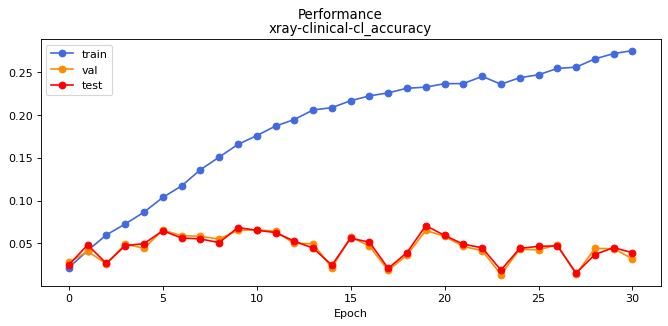

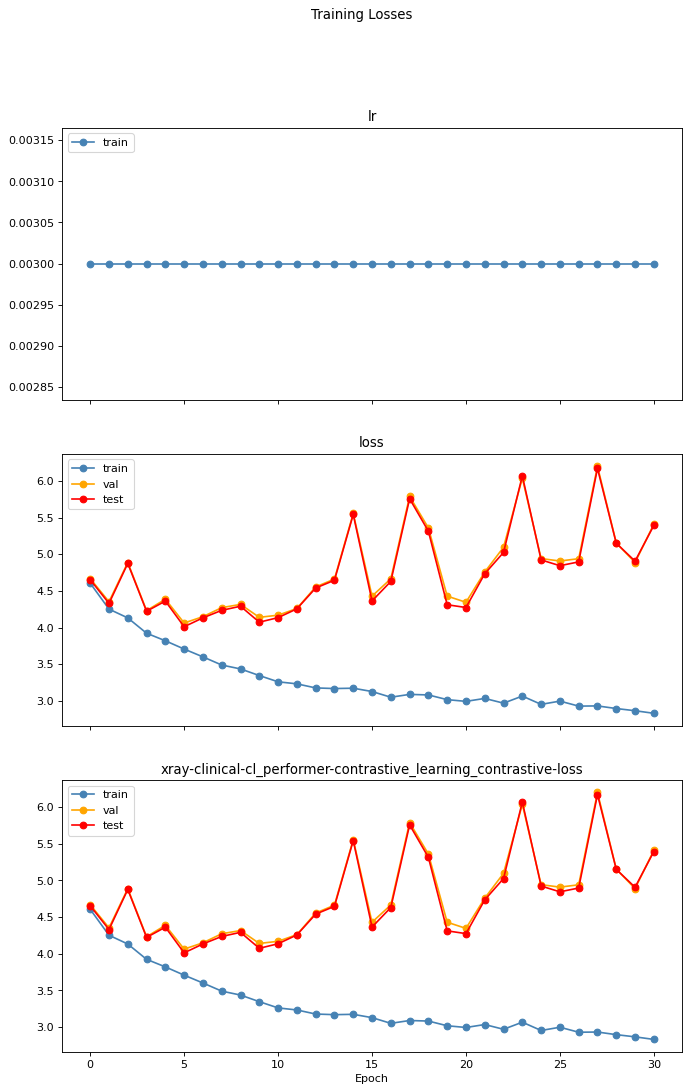

====================| Epoch [31] Done | It has took [651.45] min, Avg time: [1260.87] sec/epoch | Estimate time for [500] epochs: [10507.26] min | Epoch took [10993] sec |  xray-clinical-cl_accuracy Patience [20] |====================
==============================Trained Models==============================
====================Training model: [cl_physionet]====================
========================================For Training [cl_physionet]========================================
ModelSetup(get_performance_iou=None, get_performance_areaRng='all', name='cl_physionet', sources=['xrays', 'clinical_1d'], tasks=['xray-clinical-cl'], fusor='no-action', using_backbone_for_clinical=True, decoder_channels=[128, 64, 32, 16, 8], lesion_label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'], save_early_stop_model=True, normalise_clinical_num=True, record_training_performance=False, backbone='resnet50', optimiser='sgd', lr=0.003, wei

In [9]:
# we have to mention that in order to provide objective evaluation, we compromise the dataset size, which also nagatively afftect the performance and generlaization.
for setup in all_model_setups:

    device = clean_memory_get_device()
    reproducibility()

    assert (
        len(setup.sources) > 0 and len(setup.tasks) > 0
    ), "Need at least one source and task."

    print_f.print_title("Preparing for the training.")

    train_info = TrainingInfo(setup)

    model = create_model_from_setup(setup=setup)
    model = model.to(device)

    # load pretrained happening here.
    if len(setup.cl_pretrained_load_params) > 0:
        # load weights
        for cl_param in setup.cl_pretrained_load_params:
            print(f"Pretrained Model load for part [{cl_param.model_part}] from [{cl_param.model_name}], fix weight [{cl_param.fix_wieght}]")
            model = load_cl_pretrained(model, cl_param.model_name, cl_param.model_part, cl_param.fix_wieght)

    if "lesion-detection" in model.task_performers:
        model.task_performers["lesion-detection"].roi_heads.score_thresh = 0

    train_info.all_tasks = list(model.task_performers.keys())
    print(f" Model Size [{get_model_size_in_MB(model):.3f}] MB")

    ################ Datasets ################
    relfacx_dataset_params_dict = {
        "MIMIC_EYE_PATH": MIMIC_EYE_PATH,
        "labels_cols": setup.lesion_label_cols,
        "with_xrays_input": SourceStrs.XRAYS in setup.sources,
        "with_clincal_input": SourceStrs.CLINICAL in setup.sources or SourceStrs.CLINICAL_1D in setup.sources,
        "with_fixations_input": SourceStrs.FIXATIONS in setup.sources,
        "fixations_mode_input": setup.fiaxtions_mode_input,
        "with_bboxes_label": TaskStrs.LESION_DETECTION in setup.tasks,
        "with_fixations_label": TaskStrs.FIXATION_GENERATION in setup.tasks,
        "fixations_mode_label": setup.fiaxtions_mode_label,
        "with_chexpert_label": TaskStrs.CHEXPERT_CLASSIFICATION in setup.tasks,
        "with_negbio_label": TaskStrs.NEGBIO_CLASSIFICATION in setup.tasks,
        "clinical_numerical_cols": setup.clinical_num,
        "clinical_categorical_cols": setup.clinical_cat,
        "image_size": setup.image_size,
        "image_mean": setup.image_mean,
        "image_std": setup.image_std,
        "with_clinical_label": setup.with_clinical_label,
        "normalise_clinical_num": setup.normalise_clinical_num,
        "bbox_to_mask": setup.lesion_detection_use_mask,
        "use_clinical_df": setup.use_clinical_df,
    }


    physionet_dataset_params_dict = {
        "PHYSIONET_PATH": PHYSIONET_PATH,
        # "labels_cols": setup.lesion_label_cols,
        "with_xrays_input": SourceStrs.XRAYS in setup.sources,
        "with_clincal_input": SourceStrs.CLINICAL in setup.sources or SourceStrs.CLINICAL_1D in setup.sources,
        # "with_fixations_input": SourceStrs.FIXATIONS in setup.sources,
        # "fixations_mode_input": setup.fiaxtions_mode_input,
        # "with_bboxes_label": TaskStrs.LESION_DETECTION in setup.tasks,
        # "with_fixations_label": TaskStrs.FIXATION_GENERATION in setup.tasks,
        # "fixations_mode_label": setup.fiaxtions_mode_label,
        "with_chexpert_label": TaskStrs.CHEXPERT_CLASSIFICATION in setup.tasks,
        "with_negbio_label": TaskStrs.NEGBIO_CLASSIFICATION in setup.tasks,
        "clinical_numerical_cols": setup.clinical_num,
        "clinical_categorical_cols": setup.clinical_cat,
        "image_size": setup.image_size,
        "image_mean": setup.image_mean,
        "image_std": setup.image_std,
        "with_clinical_label": setup.with_clinical_label,
        "normalise_clinical_num": setup.normalise_clinical_num,
        # "bbox_to_mask": setup.lesion_detection_use_mask,
        # "use_clinical_df": setup.use_clinical_df,
    }

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict= physionet_dataset_params_dict if setup.use_physionet_df else relfacx_dataset_params_dict,
        using_reflacx= not setup.use_physionet_df,
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset,
        val_dataset,
        test_dataset,
        batch_size=setup.batch_size,
    )

    train_coco = None
    val_coco = None
    test_coco = None
    eval_params_dict = None

    if TaskStrs.LESION_DETECTION in setup.tasks:
        train_coco, val_coco, test_coco, eval_params_dict = get_coco_eval_params(
            source_name=SourceStrs.XRAYS,
            task_name=TaskStrs.LESION_DETECTION,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            detect_eval_dataset=detect_eval_dataset,
            iou_thrs=setup.iou_thrs,
            use_iobb=setup.use_iobb,
            maxDets=setup.maxDets,
        )

    train_info.timer.start_training()

    dynamic_loss_weight = None
    if setup.use_dynamic_weight:
        dynamic_loss_weight = get_dynamic_loss(
            loss_keys=model.get_all_losses_keys(), device=device
        )

    params = model.get_all_params(dynamic_loss_weight=dynamic_loss_weight)

    iou_types = get_iou_types(model, setup)
    optimizer = get_optimiser(params, setup)

    lr_scheduler_dict = {}

    for st in setup.performance_standards:
        lr_scheduler_dict[get_task_metric_name_from_standard(st)] = get_lr_scheduler(optimizer, setup)
    # lr_scheduler = get_lr_scheduler(optimizer, setup)

    print_f.print_title(
        f"Start training. Preparing Took [{train_info.timer.has_took_sec_from_init()}] sec"
    )

    train_info.timer.start_training()

    val_loss = None
    
    # Start the training from here.
    for e in range(1, num_epochs + 1):

        trained_model_prt = ("=" * 30) + "Trained Models" + ("=" * 30)
        print(trained_model_prt)
        for _t in train_infos:
            print(_t.best_performance_model_path)
        print(("=" * len(trained_model_prt)))

        print_f.print_title(f"Training model: [{setup.name}]")

        print(train_info)
        if dynamic_loss_weight:
            for k, v in dynamic_loss_weight.params.items():
                print(f"[{k}]: {v.item():.4f}")

        train_info.epoch = e

        train_info.timer.start_epoch()

        if (
            any(
                [
                    isinstance(p, ObjectDetectionPerformer)
                    for p in model.task_performers.values()
                ]
            )
            and train_info.epoch > setup.gt_in_train_till
        ):
            model.task_performers[
                TaskStrs.LESION_DETECTION
            ].roi_heads.use_gt_in_train = False

        ###### Perform training and show the training result here ######
        model.train()

        train_info.last_train_evaluator, train_loger = train_one_epoch(
            setup=setup,
            model=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            # data_loader=test_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
            iou_types=iou_types,
            coco=train_coco,
            evaluate_on_run=True,
            params_dict=eval_params_dict,
            dynamic_loss_weight=dynamic_loss_weight,
            return_dt_gt=True,
        )

        train_info.train_losses.append(get_data_from_metric_logger(train_loger))
        ################################################################

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()

        train_info.last_val_evaluator, val_logger = evaluate(
            setup=setup,
            model=model,
            data_loader=val_dataloader,
            device=device,
            params_dict=eval_params_dict,
            coco=val_coco,
            iou_types=iou_types,
            return_dt_gt=True,
        )

        train_info.val_losses.append(get_data_from_metric_logger(val_logger))

        train_info.performance["train"].append(
            get_performance(
                train_dataset,
                train_info.all_tasks,
                train_info.last_train_evaluator,
                iouThr=None,
                areaRng="all",
                maxDets=30,
            )
        )

        train_info.performance["val"].append(
            get_performance(
                val_dataset,
                train_info.all_tasks,
                train_info.last_val_evaluator,
                iouThr=None,
                areaRng="all",
                maxDets=30,
            )
        )

        test_performance = None
        if setup.measure_test:
            train_info.test_evaluator, test_logger = evaluate(
                setup=setup,
                model=model,
                data_loader=test_dataloader,
                device=device,
                params_dict=eval_params_dict,
                coco=test_coco,
                iou_types=iou_types,
                return_dt_gt=True,
            )
            train_info.test_losses.append(get_data_from_metric_logger(test_logger))

            test_performance = get_performance(
                test_dataset,
                train_info.all_tasks,
                train_info.test_evaluator,
            )
            train_info.performance["test"].append(test_performance)

        # update the learning rate

        # use Average Precision (Performance value) instead of loss in lr_scheduler.
        # val_loss = train_info.val_losses[-1]["loss"]
        # val_performance_value = train_info.performance["val"][-1][
        #     setup.performance_standard_task
        # ][setup.performance_standard_metric]

        val_performance_dict = {
            get_task_metric_name_from_standard(s): train_info.performance["val"][-1][s["task"]][s["metric"]]
            for s in setup.performance_standards
        }

        epoch_took, sec_already_took, speed = train_info.timer.end_epoch(
            train_info.epoch
        )

        if train_info.epoch > setup.warmup_epochs:
            if not lr_scheduler_dict is None and len(lr_scheduler_dict) > 0 :
                all_stop = []
                for st in setup.performance_standards:
                    name = get_task_metric_name_from_standard(st)
                    lr_scheduler_dict[name].step(val_performance_dict[name])
                    
                    if lr_scheduler_dict[name].num_bad_epochs > setup.real_stop_patience:
                        all_stop.append(True)
                    else: 
                        all_stop.append(False)
                        
                if setup.reduceLROnPlateau_full_stop and all(all_stop):
                    break

        # if train_info.epoch > setup.warmup_epochs:
        #     if not lr_scheduler is None:
        #         if isinstance(lr_scheduler, optim.lr_scheduler.ReduceLROnPlateau):
        #             if (
        #                 setup.reduceLROnPlateau_full_stop
        #                 and lr_scheduler.num_bad_epochs
        #                 >= setup.reduceLROnPlateau_patience
        #             ):
        #                 print_f.print_title(
        #                     f"| EarlyStop | Epoch [{train_info.epoch}] Done | It has took [{sec_already_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec |"
        #                 )
        #                 break
        #             lr_scheduler.step(val_performance_dict[get_task_metric_name_from_standard(setup.performance_standards[0])])
        #         else:
        #             lr_scheduler.step()

        # Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        # if model_setup.record_training_performance:
        # plot all matrics
        
        plot_performance(
            performance=train_info.performance,
            all_tasks=train_info.all_tasks,
            fig_title="Performance",
        )

        plot_losses(
            train_info.train_losses,
            train_info.val_losses,
            test_logers=train_info.test_losses,
        )

        print_str = f"| Epoch [{train_info.epoch}] Done | It has took [{sec_already_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec | "

        if lr_scheduler_dict and len(lr_scheduler_dict) > 0:
            for k in lr_scheduler_dict.keys():
                print_str += f" {k} Patience [{lr_scheduler_dict[k].num_bad_epochs}] |"
        # if lr_scheduler and hasattr(lr_scheduler, "num_bad_epochs"):
        #     print_str += f"Patience [{lr_scheduler.num_bad_epochs}] |"

        print_f.print_title(print_str)

        #######################################################################################
        # ignore the first 10 epoch, since the training is still warming up.
        if train_info.epoch > setup.warmup_epochs and setup.save_early_stop_model:
        # if setup.save_early_stop_model:
            val_performance_dict = {
                get_task_metric_name_from_standard(s): train_info.performance["val"][-1][s["task"]][s["metric"]]
                for s in setup.performance_standards
            }
            val_performance_dict, train_info = check_best(
                setup=setup,
                # val_performance_value=train_info.performance["val"][-1][
                #     setup.performance_standard_task
                # ][setup.performance_standard_metric],
                val_performance_dict=val_performance_dict,
                device=device,
                eval_params_dict=eval_params_dict,
                train_info=train_info,
                model=model,
                optim=optimizer,
                test_dataloader=test_dataloader,
                test_coco=test_coco,
                iou_types=iou_types,
                dynamic_weight=dynamic_loss_weight,
                test_performance=test_performance,
            )

    train_info = end_train(
        setup=setup,
        train_info=train_info,
        model=model,
        optim=optimizer,
        eval_params_dict=eval_params_dict,
        last_val_performance=train_info.performance["val"][-1][
            setup.performance_standards[0]['task']
        ][setup.performance_standards[0]['metric']],
        test_dataloader=test_dataloader,
        device=device,
        test_coco=test_coco,
        iou_types=iou_types,
        dynamic_weight=dynamic_loss_weight,
        test_performance=test_performance,
    )

    train_infos.append(train_info)

# TODO: allow for any kind of pipeline.
## bb is not resizeda
# 0.02
# 1645m 53.7s

# how to evaluate the model? print some values out.


In [10]:
# see if this one 1D+3D perform better than the baseline.

# see without backbone

# see different fusion method.

## large model

# "xray-clinical-cl_accuracy': 'xray-clinical-cl_val_accuracy_0_0366_test_accuracy_0_0288_epoch17_05-28-2023 01-01-20_cl_physionet"

#####

# why it can't be improved? it's because the dataset?
# what if I still use the clinical input, but use chexpert or negbio as labels instead? would i have the improvement consistently?

In [11]:
# what's the best training method, AP or FROC? => Go FROC => We do both at the same time.
# what's the best model? # according to what we have on mobilenet.
# what's the best fusion method?
# what's the best upsampling mechanic

# xray-clinical-cl_val_accuracy_0_0634_test_accuracy_0_0592_epoch11_05-31-2023 14-11-40_cl_physionet

# xray-clinical-cl_val_accuracy_0_0438_test_accuracy_0_0511_epoch32_06-08-2023 12-20-41_cl_physionet

In [12]:
# model.task_performers['lesion-detection'].roi_heads.box_features.shape

========================================For Training [cl_physionet]========================================
ModelSetup(get_performance_iou=None, get_performance_areaRng='all', name='cl_physionet', sources=['xrays', 'clinical_1d'], tasks=['xray-clinical-cl'], fusor='no-action', using_backbone_for_clinical=True, decoder_channels=[128, 64, 32, 16, 8], lesion_label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'], save_early_stop_model=True, normalise_clinical_num=True, record_training_performance=False, backbone='resnet50', optimiser='sgd', lr=0.003, weight_decay=0.01, sgb_momentum=0.9, image_backbone_pretrained=True, heatmap_backbone_pretrained=False, image_size=128, image_mean=[0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225], backbone_out_channels=None, batch_size=256, warmup_epochs=10, model_warmup_epochs=0, loss_warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.9999999999, reduceLROnPlateau

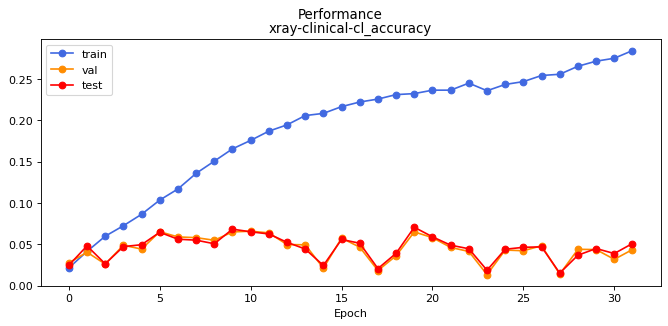

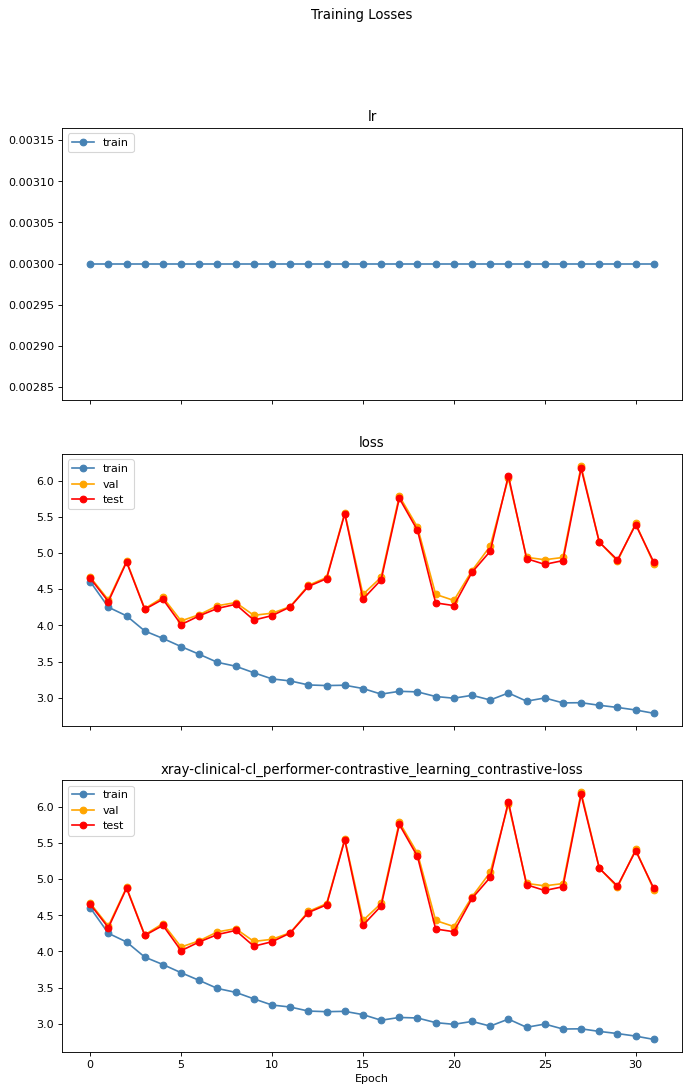

In [13]:
for t in train_infos :
    print(t)
    plot_performance(
        performance=t.performance,
        all_tasks=t.all_tasks,
        fig_title="Performance",
    )
    plot_losses(
        t.train_losses,
        t.val_losses,
        test_logers=t.test_losses,
    )

In [14]:
for t in train_infos :
    print_f.print_title(t.model_setup.name)
    for k, v in t.best_performance_model_path.items():
        print(f"{k}: {v}")

    print(t.final_model_path)

====================cl_physionet====================
xray-clinical-cl_accuracy: xray-clinical-cl_val_accuracy_0_0660_test_accuracy_0_0653_epoch11_06-06-2023 02-50-07_cl_physionet
xray-clinical-cl_val_accuracy_0_0438_test_accuracy_0_0511_epoch32_06-08-2023 12-20-41_cl_physionet


In [15]:


# ====================baseline_mobilenet==================== (128)
# lesion-detection_ap: lesion-detection_val_ap_0_0856_test_ap_0_0693_epoch67_05-23-2023 13-53-13_baseline_mobilenet
# lesion-detection_froc: lesion-detection_val_froc_0_7026_test_froc_0_6542_epoch65_05-23-2023 13-48-49_baseline_mobilenet
# lesion-detection_ar: lesion-detection_val_ar_0_5670_test_ar_0_6047_epoch32_05-23-2023 12-31-19_baseline_mobilenet
# lesion-detection_val_ap_0_0619_test_ap_0_0608_epoch78_05-23-2023 14-17-33_baseline_mobilenet


# ====================baseline_mobilenet==================== (512)
# lesion-detection_ap: lesion-detection_val_ap_0_1283_test_ap_0_1174_epoch42_05-23-2023 16-38-06_baseline_mobilenet
# lesion-detection_froc: lesion-detection_val_froc_0_8600_test_froc_0_7792_epoch41_05-23-2023 16-34-51_baseline_mobilenet
# lesion-detection_ar: lesion-detection_val_ar_0_6982_test_ar_0_6462_epoch41_05-23-2023 16-34-52_baseline_mobilenet
# lesion-detection_val_ap_0_1172_test_ap_0_1203_epoch53_05-23-2023 17-14-15_baseline_mobilenet


# chexpert image size

# ====================128_image_chexpert====================
# chexpert-classification_auc: chexpert-classification_val_auc_0_6936_test_auc_0_7522_epoch27_05-24-2023 05-18-38_128_image_chexpert
# chexpert-classification_val_auc_0_6658_test_auc_0_6892_epoch38_05-24-2023 05-36-16_128_image_chexpert
# ====================512_image_chexpert====================
# chexpert-classification_auc: chexpert-classification_val_auc_0_7245_test_auc_0_7784_epoch41_05-24-2023 06-47-09_512_image_chexpert
# chexpert-classification_val_auc_0_6691_test_auc_0_7406_epoch52_05-24-2023 07-05-02_512_image_chexpert

# (image_size = 128, batch_size=4)
# ====================load_test==================== (fix_weight)
# chexpert-classification_auc: chexpert-classification_val_auc_0_6880_test_auc_0_7527_epoch48_05-25-2023 00-20-36_load_test
# chexpert-classification_val_auc_0_6329_test_auc_0_6750_epoch69_05-25-2023 01-05-23_load_test
# ====================load_test==================== (no fix weight)
# chexpert-classification_auc: chexpert-classification_val_auc_0_7180_test_auc_0_7344_epoch35_05-25-2023 02-23-35_load_test
# chexpert-classification_val_auc_0_6938_test_auc_0_7593_epoch56_05-25-2023 03-09-59_load_test




In [16]:
len(train_dataset) + len(val_dataset) + len(test_dataset)

67263

In [17]:
# ====================baseline_mobilenet====================
# lesion-detection_ap: lesion-detection_val_ap_0_1281_test_ap_0_1180_epoch49_05-17-2023 18-16-58_baseline_mobilenet
# lesion-detection_froc: lesion-detection_val_froc_0_8257_test_froc_0_7691_epoch35_05-17-2023 17-46-23_baseline_mobilenet
# lesion-detection_ar: lesion-detection_val_ar_0_6853_test_ar_0_6706_epoch55_05-17-2023 18-30-08_baseline_mobilenet
# lesion-detection_val_ap_0_1039_test_ap_0_0914_epoch66_05-17-2023 18-54-13_baseline_mobilenet
# ====================clinical_mobilenet_sum====================
# lesion-detection_ap: lesion-detection_val_ap_0_1542_test_ap_0_1294_epoch60_05-17-2023 21-23-17_clinical_mobilenet_sum
# lesion-detection_froc: lesion-detection_val_froc_0_8014_test_froc_0_7331_epoch31_05-17-2023 20-03-34_clinical_mobilenet_sum
# lesion-detection_ar: lesion-detection_val_ar_0_7262_test_ar_0_6562_epoch53_05-17-2023 21-04-16_clinical_mobilenet_sum
# lesion-detection_val_ap_0_1304_test_ap_0_1291_epoch71_05-17-2023 21-54-43_clinical_mobilenet_sum
# ====================clinical_mobilenet_hadamard====================
# lesion-detection_ap: lesion-detection_val_ap_0_1296_test_ap_0_1427_epoch35_05-17-2023 23-33-46_clinical_mobilenet_hadamard
# lesion-detection_froc: lesion-detection_val_froc_0_8369_test_froc_0_7545_epoch25_05-17-2023 23-06-47_clinical_mobilenet_hadamard
# lesion-detection_ar: lesion-detection_val_ar_0_7103_test_ar_0_7143_epoch35_05-17-2023 23-33-46_clinical_mobilenet_hadamard
# lesion-detection_val_ap_0_1205_test_ap_0_1253_epoch46_05-18-2023 00-03-24_clinical_mobilenet_hadamard
# ====================clinical_mobilenet_concat_conv==================== () = STANDARD
# lesion-detection_ap: lesion-detection_val_ap_0_1272_test_ap_0_1639_epoch35_05-18-2023 01-43-56_clinical_mobilenet_concat_conv
# lesion-detection_froc: lesion-detection_val_froc_0_8185_test_froc_0_8069_epoch29_05-18-2023 01-26-37_clinical_mobilenet_concat_conv #(highest froc)
# lesion-detection_ar: lesion-detection_val_ar_0_6764_test_ar_0_7112_epoch39_05-18-2023 01-53-58_clinical_mobilenet_concat_conv
# lesion-detection_val_ap_0_1029_test_ap_0_1023_epoch50_05-18-2023 02-23-43_clinical_mobilenet_concat_conv
# ====================clinical_mobilenet_concat_linear====================
# lesion-detection_ap: lesion-detection_val_ap_0_1294_test_ap_0_1415_epoch55_05-18-2023 04-57-29_clinical_mobilenet_concat_linear
# lesion-detection_froc: lesion-detection_val_froc_0_8233_test_froc_0_7907_epoch32_05-18-2023 03-48-49_clinical_mobilenet_concat_linear
# lesion-detection_ar: lesion-detection_val_ar_0_6971_test_ar_0_7004_epoch50_05-18-2023 04-42-26_clinical_mobilenet_concat_linear
# lesion-detection_val_ap_0_0947_test_ap_0_0852_epoch66_05-18-2023 05-29-12_clinical_mobilenet_concat_linear
# ====================clinical_mobilenet_concat_convb==================== (without block will be better)
# lesion-detection_ap: lesion-detection_val_ap_0_1252_test_ap_0_1343_epoch61_05-18-2023 09-09-04_clinical_mobilenet_concat_convb
# lesion-detection_froc: lesion-detection_val_froc_0_8047_test_froc_0_7226_epoch32_05-18-2023 07-51-15_clinical_mobilenet_concat_convb
# lesion-detection_ar: lesion-detection_val_ar_0_7094_test_ar_0_6383_epoch52_05-18-2023 08-40-51_clinical_mobilenet_concat_convb
# lesion-detection_val_ap_0_1083_test_ap_0_1275_epoch72_05-18-2023 09-40-50_clinical_mobilenet_concat_convb

# retrained.

# ====================clinical_mobilenet_concat_convb_nb====================
# lesion-detection_ap: lesion-detection_val_ap_0_1220_test_ap_0_1149_epoch42_05-18-2023 22-56-01_clinical_mobilenet_concat_convb_nb
# lesion-detection_froc: lesion-detection_val_froc_0_8020_test_froc_0_7185_epoch30_05-18-2023 22-28-31_clinical_mobilenet_concat_convb_nb
# lesion-detection_ar: lesion-detection_val_ar_0_6927_test_ar_0_6805_epoch44_05-18-2023 23-00-42_clinical_mobilenet_concat_convb_nb
# lesion-detection_val_ap_0_1154_test_ap_0_1044_epoch55_05-18-2023 23-27-19_clinical_mobilenet_concat_convb_nb
# ====================clinical_mobilenet_concat_conv_inter====================
# lesion-detection_ap: lesion-detection_val_ap_0_1233_test_ap_0_1402_epoch42_05-19-2023 01-13-45_clinical_mobilenet_concat_conv_inter
# lesion-detection_froc: lesion-detection_val_froc_0_8402_test_froc_0_7701_epoch26_05-19-2023 00-31-44_clinical_mobilenet_concat_conv_inter
# lesion-detection_ar: lesion-detection_val_ar_0_6676_test_ar_0_6893_epoch39_05-19-2023 01-05-30_clinical_mobilenet_concat_conv_inter
# lesion-detection_val_ap_0_1071_test_ap_0_1086_epoch53_05-19-2023 01-43-47_clinical_mobilenet_concat_conv_inter
# ====================clinical_mobilenet_concat_conv_repeat====================
# lesion-detection_ap: lesion-detection_val_ap_0_1348_test_ap_0_1446_epoch60_05-19-2023 04-13-39_clinical_mobilenet_concat_conv_repeat
# lesion-detection_froc: lesion-detection_val_froc_0_8312_test_froc_0_7636_epoch27_05-19-2023 02-54-07_clinical_mobilenet_concat_conv_repeat
# lesion-detection_ar: lesion-detection_val_ar_0_6960_test_ar_0_6861_epoch60_05-19-2023 04-13-40_clinical_mobilenet_concat_conv_repeat
# lesion-detection_val_ap_0_1085_test_ap_0_1055_epoch71_05-19-2023 04-39-38_clinical_mobilenet_concat_conv_repeat

# ====================clinical_mobilenet_concat_deform====================
# lesion-detection_ap: lesion-detection_val_ap_0_1405_test_ap_0_1231_epoch47_05-19-2023 07-34-33_clinical_mobilenet_concat_deform
# lesion-detection_froc: lesion-detection_val_froc_0_7905_test_froc_0_7824_epoch25_05-19-2023 06-14-09_clinical_mobilenet_concat_deform
# lesion-detection_ar: lesion-detection_val_ar_0_6924_test_ar_0_6500_epoch52_05-19-2023 07-52-47_clinical_mobilenet_concat_deform
# lesion-detection_val_ap_0_0905_test_ap_0_0844_epoch63_05-19-2023 08-33-16_clinical_mobilenet_concat_deform

###### no warm up
# conv2d seems the best, let dig into the block design.

# no backbone. #(compared to clinical_mobilenet_concat_conv above, ap is worse, froc worse, ar worse.)
# ====================clinical_mobilenet_concat_conv_nb====================
# lesion-detection_ap: lesion-detection_val_ap_0_1444_test_ap_0_1089_epoch57_05-18-2023 12-12-07_clinical_mobilenet_concat_conv_nb
# lesion-detection_froc: lesion-detection_val_froc_0_9349_test_froc_0_7247_epoch6_05-18-2023 10-05-15_clinical_mobilenet_concat_conv_nb
# lesion-detection_ar: lesion-detection_val_ar_0_7180_test_ar_0_6810_epoch51_05-18-2023 11-57-55_clinical_mobilenet_concat_conv_nb
# lesion-detection_val_ap_0_1382_test_ap_0_1188_epoch72_05-18-2023 12-45-49_clinical_mobilenet_concat_conv_nb

# ====================clinical_mobilenet_concat_conv_inter====================
# lesion-detection_ap: lesion-detection_val_ap_0_1265_test_ap_0_1518_epoch30_05-18-2023 14-08-50_clinical_mobilenet_concat_conv_inter
# lesion-detection_froc: lesion-detection_val_froc_0_9136_test_froc_0_2544_epoch3_05-18-2023 13-07-19_clinical_mobilenet_concat_conv_inter
# lesion-detection_ar: lesion-detection_val_ar_0_7133_test_ar_0_6912_epoch30_05-18-2023 14-08-50_clinical_mobilenet_concat_conv_inter
# lesion-detection_val_ap_0_0955_test_ap_0_1092_epoch41_05-18-2023 14-37-22_clinical_mobilenet_concat_conv_inter
# ====================clinical_mobilenet_concat_conv_repeat====================
# lesion-detection_ap: lesion-detection_val_ap_0_1429_test_ap_0_1180_epoch61_05-18-2023 18-09-52_clinical_mobilenet_concat_conv_repeat
# lesion-detection_froc: lesion-detection_val_froc_1_3513_test_froc_0_5398_epoch6_05-18-2023 14-57-53_clinical_mobilenet_concat_conv_repeat
# lesion-detection_ar: lesion-detection_val_ar_0_6967_test_ar_0_6787_epoch52_05-18-2023 17-38-25_clinical_mobilenet_concat_conv_repeat
# lesion-detection_val_ap_0_0959_test_ap_0_0939_epoch72_05-18-2023 18-48-39_clinical_mobilenet_concat_conv_repeat

### DenseNet161
# ====================baseline_densenet====================
# lesion-detection_ap: lesion-detection_val_ap_0_1216_test_ap_0_1208_epoch22_05-19-2023 17-02-29_baseline_densenet
# lesion-detection_froc: lesion-detection_val_froc_0_8454_test_froc_0_7605_epoch13_05-19-2023 16-37-53_baseline_densenet
# lesion-detection_ar: lesion-detection_val_ar_0_6769_test_ar_0_6854_epoch32_05-19-2023 17-29-08_baseline_densenet
# lesion-detection_val_ap_0_0963_test_ap_0_1141_epoch43_05-19-2023 17-58-40_baseline_densenet
# ====================clinical_densenet_concat====================
# lesion-detection_ap: lesion-detection_val_ap_0_1364_test_ap_0_1181_epoch47_05-19-2023 20-32-24_clinical_densenet_concat
# lesion-detection_froc: lesion-detection_val_froc_0_8265_test_froc_0_6868_epoch44_05-19-2023 20-22-35_clinical_densenet_concat
# lesion-detection_ar: lesion-detection_val_ar_0_6837_test_ar_0_6633_epoch44_05-19-2023 20-22-36_clinical_densenet_concat
# lesion-detection_val_ap_0_0967_test_ap_0_1094_epoch58_05-19-2023 23-59-55_clinical_densenet_concat
# ====================clinical_densenet_hadamard====================
# lesion-detection_ap: lesion-detection_val_ap_0_1288_test_ap_0_1039_epoch27_05-20-2023 07-22-17_clinical_densenet_hadamard
# lesion-detection_froc: lesion-detection_val_froc_0_8345_test_froc_0_7378_epoch28_05-20-2023 07-42-27_clinical_densenet_hadamard
# lesion-detection_ar: lesion-detection_val_ar_0_7076_test_ar_0_6752_epoch23_05-20-2023 06-18-40_clinical_densenet_hadamard
# lesion-detection_val_ap_0_1155_test_ap_0_1032_epoch39_05-20-2023 09-12-00_clinical_densenet_hadamard


### ResNet18

# ====================baseline_resnet18====================
# lesion-detection_ap: lesion-detection_val_ap_0_1278_test_ap_0_1455_epoch33_05-20-2023 12-52-07_baseline_resnet18
# lesion-detection_froc: lesion-detection_val_froc_0_8341_test_froc_0_8126_epoch17_05-20-2023 11-57-28_baseline_resnet18
# lesion-detection_ar: lesion-detection_val_ar_0_6807_test_ar_0_6477_epoch44_05-20-2023 13-30-19_baseline_resnet18
# lesion-detection_val_ap_0_1063_test_ap_0_1135_epoch55_05-20-2023 14-08-42_baseline_resnet18
# ====================clinical_resnet18_concat====================
# lesion-detection_ap: lesion-detection_val_ap_0_1400_test_ap_0_1423_epoch36_05-20-2023 16-21-30_clinical_resnet18_concat
# lesion-detection_froc: lesion-detection_val_froc_0_8168_test_froc_0_7923_epoch31_05-20-2023 16-03-09_clinical_resnet18_concat
# lesion-detection_ar: lesion-detection_val_ar_0_6996_test_ar_0_6663_epoch36_05-20-2023 16-21-31_clinical_resnet18_concat
# lesion-detection_val_ap_0_1342_test_ap_0_1380_epoch47_05-20-2023 17-02-51_clinical_resnet18_concat
# ====================clinical_resnet18_hadamard====================
# lesion-detection_ap: lesion-detection_val_ap_0_1301_test_ap_0_1152_epoch27_05-20-2023 18-43-20_clinical_resnet18_hadamard
# lesion-detection_froc: lesion-detection_val_froc_0_8364_test_froc_0_6936_epoch27_05-20-2023 18-43-21_clinical_resnet18_hadamard
# lesion-detection_ar: lesion-detection_val_ar_0_6747_test_ar_0_6730_epoch27_05-20-2023 18-43-22_clinical_resnet18_hadamard
# lesion-detection_val_ap_0_1093_test_ap_0_1104_epoch38_05-20-2023 19-25-00_clinical_resnet18_hadamard

### ConvNext 
# ====================baseline_convnext_base====================
# lesion-detection_ap: lesion-detection_val_ap_0_1586_test_ap_0_1965_epoch60_05-21-2023 07-07-50_baseline_convnext_base
# lesion-detection_froc: lesion-detection_val_froc_0_8393_test_froc_0_8175_epoch48_05-21-2023 06-22-48_baseline_convnext_base
# lesion-detection_ar: lesion-detection_val_ar_0_7384_test_ar_0_7275_epoch60_05-21-2023 07-07-52_baseline_convnext_base
# lesion-detection_val_ap_0_1036_test_ap_0_0965_epoch71_05-21-2023 07-49-26_baseline_convnext_base
# ====================clinical_convnext_base_concat====================
# lesion-detection_ap: lesion-detection_val_ap_0_1311_test_ap_0_1501_epoch42_05-21-2023 10-13-48_clinical_convnext_base_concat
# lesion-detection_froc: lesion-detection_val_froc_0_8223_test_froc_0_7719_epoch37_05-21-2023 09-57-25_clinical_convnext_base_concat
# lesion-detection_ar: lesion-detection_val_ar_0_6928_test_ar_0_7037_epoch39_05-21-2023 10-04-02_clinical_convnext_base_concat
# lesion-detection_val_ap_0_1104_test_ap_0_1210_epoch53_05-21-2023 10-49-50_clinical_convnext_base_concat
# ====================clinical_convnext_base_hadamard====================
# lesion-detection_ap: lesion-detection_val_ap_0_1495_test_ap_0_1234_epoch50_05-21-2023 15-52-11_clinical_convnext_base_hadamard
# lesion-detection_froc: lesion-detection_val_froc_0_8206_test_froc_0_7357_epoch54_05-21-2023 16-10-07_clinical_convnext_base_hadamard
# lesion-detection_ar: lesion-detection_val_ar_0_7383_test_ar_0_7251_epoch39_05-21-2023 15-02-48_clinical_convnext_base_hadamard
# lesion-detection_val_ap_0_1119_test_ap_0_1061_epoch65_05-21-2023 16-59-29_clinical_convnext_base_hadamard


### Efficientnet_b0

# ====================baseline_efficientnet_b0====================
# lesion-detection_ap: lesion-detection_val_ap_0_1111_test_ap_0_1318_epoch36_05-22-2023 06-42-43_baseline_efficientnet_b0
# lesion-detection_froc: lesion-detection_val_froc_0_8424_test_froc_0_7637_epoch34_05-22-2023 06-38-28_baseline_efficientnet_b0
# lesion-detection_ar: lesion-detection_val_ar_0_6947_test_ar_0_6929_epoch36_05-22-2023 06-42-43_baseline_efficientnet_b0
# lesion-detection_val_ap_0_1083_test_ap_0_1198_epoch47_05-22-2023 07-06-14_baseline_efficientnet_b0
# ====================clinical_efficientnet_b0_concat====================
# lesion-detection_ap: lesion-detection_val_ap_0_1104_test_ap_0_1200_epoch42_05-22-2023 08-40-51_clinical_efficientnet_b0_concat
# lesion-detection_froc: lesion-detection_val_froc_0_7955_test_froc_0_7537_epoch34_05-22-2023 08-22-39_clinical_efficientnet_b0_concat
# lesion-detection_ar: lesion-detection_val_ar_0_6793_test_ar_0_7287_epoch38_05-22-2023 08-31-50_clinical_efficientnet_b0_concat
# lesion-detection_val_ap_0_1032_test_ap_0_1210_epoch53_05-22-2023 09-05-59_clinical_efficientnet_b0_concat
# ====================clinical_efficientnet_b0_hadamard====================
# lesion-detection_ap: lesion-detection_val_ap_0_1215_test_ap_0_1190_epoch33_05-22-2023 10-20-56_clinical_efficientnet_b0_hadamard
# lesion-detection_froc: lesion-detection_val_froc_0_8208_test_froc_0_7642_epoch51_05-22-2023 11-02-34_clinical_efficientnet_b0_hadamard
# lesion-detection_ar: lesion-detection_val_ar_0_6967_test_ar_0_6720_epoch44_05-22-2023 10-46-14_clinical_efficientnet_b0_hadamard
# lesion-detection_val_ap_0_1011_test_ap_0_1059_epoch62_05-22-2023 11-28-24_clinical_efficientnet_b0_hadamard


### ResNet50

# ====================baseline_resnet50====================
# lesion-detection_ap: lesion-detection_val_ap_0_1411_test_ap_0_1225_epoch24_05-22-2023 18-56-26_baseline_resnet50
# lesion-detection_froc: lesion-detection_val_froc_0_8487_test_froc_0_7269_epoch33_05-22-2023 19-26-23_baseline_resnet50
# lesion-detection_ar: lesion-detection_val_ar_0_7003_test_ar_0_6575_epoch32_05-22-2023 19-23-05_baseline_resnet50
# lesion-detection_val_ap_0_1368_test_ap_0_0960_epoch44_05-22-2023 20-02-59_baseline_resnet50
# ====================clinical_resnet50_concat====================
# lesion-detection_ap: lesion-detection_val_ap_0_1368_test_ap_0_1242_epoch57_05-22-2023 23-38-00_clinical_resnet50_concat
# lesion-detection_froc: lesion-detection_val_froc_0_8288_test_froc_0_7680_epoch18_05-22-2023 21-09-38_clinical_resnet50_concat
# lesion-detection_ar: lesion-detection_val_ar_0_6725_test_ar_0_6765_epoch36_05-22-2023 22-17-23_clinical_resnet50_concat
# lesion-detection_val_ap_0_1041_test_ap_0_1008_epoch68_05-23-2023 00-19-37_clinical_resnet50_concat
# ====================clinical_resnet50_hadamard====================
# lesion-detection_ap: lesion-detection_val_ap_0_1305_test_ap_0_1232_epoch22_05-23-2023 01-32-10_clinical_resnet50_hadamard
# lesion-detection_froc: lesion-detection_val_froc_0_8309_test_froc_0_7785_epoch15_05-23-2023 01-14-35_clinical_resnet50_hadamard
# lesion-detection_ar: lesion-detection_val_ar_0_7034_test_ar_0_7171_epoch35_05-23-2023 02-04-52_clinical_resnet50_hadamard
# lesion-detection_val_ap_0_1141_test_ap_0_0982_epoch46_05-23-2023 02-32-43_clinical_resnet50_hadamard



In [18]:
# try 10k dataset.





In [19]:
# test one more, concat conv block

# {'lesion-detection_ap': 'lesion-detection_val_ap_0_1216_test_ap_0_1208_epoch22_05-19-2023 17-02-29_baseline_densenet', 'lesion-detection_froc': 'lesion-detection_val_froc_0_8454_test_froc_0_7605_epoch13_05-19-2023 16-37-53_baseline_densenet', 'lesion-detection_ar': 'lesion-detection_val_ar_0_6769_test_ar_0_6854_epoch32_05-19-2023 17-29-08_baseline_densenet'}
# {'lesion-detection_ap': 'lesion-detection_val_ap_0_1364_test_ap_0_1181_epoch47_05-19-2023 20-32-24_clinical_densenet_concat', 'lesion-detection_froc': 'lesion-detection_val_froc_0_8265_test_froc_0_6868_epoch44_05-19-2023 20-22-35_clinical_densenet_concat', 'lesion-detection_ar': 'lesion-detection_val_ar_0_6837_test_ar_0_6633_epoch44_05-19-2023 20-22-36_clinical_densenet_concat'}
# ==========================================================================

In [20]:
# ====================clinical_convnext_base_sum==================== (3D)
# lesion-detection_ap: lesion-detection_val_ap_0_1375_test_ap_0_1823_epoch22_05-16-2023 18-23-36_clinical_convnext_base_sum
# lesion-detection_froc: lesion-detection_val_froc_0_8378_test_froc_0_7804_epoch26_05-16-2023 18-36-07_clinical_convnext_base_sum
# lesion-detection_ar: lesion-detection_val_ar_0_6835_test_ar_0_6754_epoch39_05-16-2023 19-17-06_clinical_convnext_base_sum



# base 17.84 (AP), 

In [21]:
# for train_info in train_infos :
#     print(train_info.final_model_path)

In [22]:
# the baseline model is too great.

# val_lesion-detection_froc_0_8214_test_lesion-detection_froc_0_7215_epoch29_05-08-2023 03-29-15_lesion_dsetection_baseline_mobilenet
# val_lesion-detection_froc_0_7802_test_lesion-detection_froc_0_7193_epoch27_05-08-2023 04-57-59_lesion_dsetection_with_clinical_mobilenet  # (1D+3D)
# val_lesion-detection_froc_0_8345_test_lesion-detection_froc_0_7381_epoch31_05-08-2023 08-28-01_lesion_dsetection_with_clinical_mobilenet  # (3D only)

# val_lesion-detection_froc_0_8262_test_lesion-detection_froc_0_7828_epoch21_05-08-2023 10-52-48_lesion_dsetection_baseline_resnet18
# val_lesion-detection_froc_0_8063_test_lesion-detection_froc_0_7156_epoch21_05-08-2023 17-24-35_lesion_dsetection_with_clinical_resnet18 # (1D+3D)
# val_lesion-detection_froc_0_8391_test_lesion-detection_froc_0_7007_epoch51_05-09-2023 00-03-18_lesion_dsetection_with_clinical_resnet18 # (3D only)

# val_lesion-detection_froc_0_8422_test_lesion-detection_froc_0_7991_epoch39_05-09-2023 03-20-36_lesion_dsetection_baseline_convnext_base
# val_lesion-detection_froc_0_8248_test_lesion-detection_froc_0_7867_epoch45_05-09-2023 07-31-28_lesion_dsetection_with_clinical_convnext_base_1D_3D
# val_lesion-detection_froc_0_8104_test_lesion-detection_froc_0_7584_epoch62_05-09-2023 12-56-34_lesion_dsetection_with_clinical_convnext_base_3D

# val_lesion-detection_froc_0_8148_test_lesion-detection_froc_0_7649_epoch39_05-09-2023 17-27-41_lesion_dsetection_with_clinical_convnext_base_3D
# val_lesion-detection_froc_0_8409_test_lesion-detection_froc_0_8003_epoch29_05-09-2023 19-09-54_lesion_dsetection_with_clinical_convnext_base_1D_3D
# val_lesion-detection_froc_0_8597_test_lesion-detection_froc_0_8035_epoch41_05-09-2023 21-40-22_lesion_dsetection_baseline_convnext_base

# val_lesion-detection_froc_0_8301_test_lesion-detection_froc_0_7479_epoch23_05-09-2023 23-23-11_lesion_dsetection_baseline_efficientnet_b0
# val_lesion-detection_froc_0_7876_test_lesion-detection_froc_0_7051_epoch35_05-10-2023 07-17-37_lesion_dsetection_with_clinical_efficientnet_b0_1D_3D
# val_lesion-detection_froc_0_8321_test_lesion-detection_froc_0_7246_epoch25_05-10-2023 09-19-11_lesion_dsetection_with_clinical_efficientnet_b0_3D

# val_lesion-detection_froc_0_8442_test_lesion-detection_froc_0_6942_epoch33_05-10-2023 17-06-03_lesion_dsetection_baseline_densenet
# val_lesion-detection_froc_0_8303_test_lesion-detection_froc_0_7089_epoch33_05-10-2023 19-11-45_lesion_dsetection_with_clinical_densenet_1D_3D
# val_lesion-detection_froc_0_8310_test_lesion-detection_froc_0_7144_epoch12_05-10-2023 20-13-22_lesion_dsetection_with_clinical_densenet_3D 

# val_lesion-detection_froc_0_8350_test_lesion-detection_froc_0_7959_epoch15_05-10-2023 21-30-40_lesion_dsetection_baseline_resnet50
# val_lesion-detection_froc_0_8119_test_lesion-detection_froc_0_7458_epoch15_05-10-2023 22-32-10_lesion_dsetection_with_clinical_resnet50_1D_3D
# val_lesion-detection_froc_0_8260_test_lesion-detection_froc_0_7630_epoch15_05-10-2023 23-35-14_lesion_dsetection_with_clinical_resnet50_3D

# val_lesion-detection_froc_0_8016_test_lesion-detection_froc_0_7337_epoch35_05-11-2023 01-44-17_lesion_dsetection_baseline_efficientnet_b5
# val_lesion-detection_froc_0_8027_test_lesion-detection_froc_0_6531_epoch26_05-11-2023 03-42-43_lesion_dsetection_with_clinical_efficientnet_b5_1D_3D
# val_lesion-detection_froc_0_8209_test_lesion-detection_froc_0_6131_epoch34_05-11-2023 06-05-03_lesion_dsetection_with_clinical_efficientnet_b5_3D

# val_lesion-detection_froc_0_8236_test_lesion-detection_froc_0_7954_epoch42_05-11-2023 14-58-09_lesion_dsetection_with_clinical_convnext_base_3D_hadamard
# val_lesion-detection_froc_0_7650_test_lesion-detection_froc_0_7231_epoch25_05-11-2023 19-32-51_lesion_dsetection_with_clinical_convnext_base_3D_cocat_token_mixer
# val_lesion-detection_froc_0_8186_test_lesion-detection_froc_0_7648_epoch61_05-11-2023 22-43-35_lesion_dsetection_with_clinical_convnext_base_3D_hadamard

# val_lesion-detection_froc_0_8453_test_lesion-detection_froc_0_7186_epoch51_05-12-2023 02-57-57_lesion_dsetection_with_clinical_expander_convnext_base_3D_cocat
# val_lesion-detection_froc_0_7863_test_lesion-detection_froc_0_7991_epoch13_05-12-2023 04-03-12_lesion_dsetection_with_clinical_convnext_base_3D_cocat
# val_lesion-detection_froc_0_7976_test_lesion-detection_froc_0_7680_epoch28_05-12-2023 15-26-58_lesion_dsetection_with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer

# val_lesion-detection_froc_0_7897_test_lesion-detection_froc_0_7916_epoch18_05-12-2023 17-26-12_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_10
# val_lesion-detection_froc_0_7830_test_lesion-detection_froc_0_7933_epoch13_05-12-2023 18-53-20_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_10

# val_lesion-detection_froc_0_8070_test_lesion-detection_froc_0_7986_epoch18_05-12-2023 21-53-37_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_10
# val_lesion-detection_froc_0_7888_test_lesion-detection_froc_0_7747_epoch13_05-12-2023 23-17-06_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_100

# val_lesion-detection_froc_0_8227_test_lesion-detection_froc_0_7324_epoch70_05-13-2023 04-26-25_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_10
# val_lesion-detection_froc_0_8216_test_lesion-detection_froc_0_7314_epoch65_05-13-2023 07-51-16_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_100

'''
AP based models.
'''

# val_lesion-detection_ap_0_1290_test_lesion-detection_ap_0_1564_epoch60_05-14-2023 00-32-39_lesion_dsetection_with_clinical_convnext_base_3D
# val_lesion-detection_ap_0_0970_test_lesion-detection_ap_0_1072_epoch56_05-14-2023 03-54-58_lesion_dsetection_with_clinical_convnext_base_1D_3D
# val_lesion-detection_ap_0_1309_test_lesion-detection_ap_0_1245_epoch56_05-14-2023 07-09-35_lesion_dsetection_baseline_convnext_base

# val_lesion-detection_ap_0_1138_test_lesion-detection_ap_0_1088_epoch68_05-14-2023 17-09-14_clinical_efficientnet_b0_3D
# val_lesion-detection_ap_0_1202_test_lesion-detection_ap_0_1081_epoch30_05-14-2023 19-10-56_clinical_efficientnet_b0_1D_3D
# val_lesion-detection_ap_0_1127_test_lesion-detection_ap_0_1156_epoch36_05-14-2023 21-39-07_baseline_efficientnet_b0

# val_lesion-detection_ap_0_1240_test_lesion-detection_ap_0_1129_epoch56_05-15-2023 13-04-42_clinical_densenet_3D
# val_lesion-detection_ap_0_1182_test_lesion-detection_ap_0_1200_epoch26_05-15-2023 16-25-55_clinical_densenet_1D_3D
# val_lesion-detection_ap_0_1382_test_lesion-detection_ap_0_1230_epoch21_05-15-2023 18-19-01_baseline_densenet

## 7584

## currently, the best model is convnext. (let's see how this interact with other fusors.)
## justification. is it because the overfitting promoted?
## Laplacian Pyramid Fusion
## Sparse Representation Fusion



'\nAP based models.\n'

In [23]:
# import matplotlib.pyplot as plt
# from models.utils import get_model_size_in_MB

# get_model_size_in_MB(model)
# print(setup.name)

# import pickle

# # with open('baseline_cpu_memory.pkl', 'wb') as f:
# #     pickle.dump(MemoryUsageReocrds.cpu_memory, f)
# with open('baseline_cpu_memory.pkl', 'rb') as f:
#     baseline_cpu_memory = pickle.load(f)

# plt.plot(MemoryUsageReocrds.cpu_memory)
# # plt.plot(baseline_cpu_memory)

In [24]:
# Clinical training.
# val_lesion-detection_froc_0_8000_test_lesion-detection_froc_0_7137_epoch34_05-07-2023 02-16-11_lesion_dsetection_with_clinical_mobilenet
# 

In [25]:
# chexpert
# baseline: val_chexpert-classification_auc_0_7189_test_chexpert-classification_auc_0_7160_epoch32_04-08-2023 16-41-18_chexpert_resnet50_baseline
# with_fix: val_chexpert-classification_auc_0_7059_test_chexpert-classification_auc_0_7133_epoch30_04-08-2023 22-58-36_chexpert_resnet50_with_fix

#negbio
# baseline: val_negbio-classification_auc_0_7149_test_negbio-classification_auc_0_7226_epoch37_04-09-2023 19-32-09_negbio_resnet50_baseline
# with_fix: val_negbio-classification_auc_0_7115_test_negbio-classification_auc_0_7030_epoch22_04-10-2023 00-47-31_negbio_resnet50_with_fix

# clinical prediction
# val_gender-classification_accuracy_0_7556_test_gender-classification_accuracy_0_5956_epoch49_04-10-2023 15-12-18_clinical_predictions


# seperate them for just training the gender, see if it can be improved.

# val_gender-classification_accuracy_0_9556_test_gender-classification_accuracy_0_9338_epoch16_04-11-2023 13-54-11_clinical_predictions
# val_age-regression_r2_0_0652_test_age-regression_r2_0_0416_epoch40_04-11-2023 20-34-04_age_predictions

# only final model, dont' know why the best model is not saved.
# norm age: val_age-regression_r2_-3_5081_test_age-regression_r2_-3_5163_epoch100_04-12-2023 12-01-41_age_predictions_norm
